ModuleNotFoundError: ignored

In [24]:
!pip install d2l==0.17.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                    nn.Linear(120, 84), nn.Sigmoid(), nn.Linear(84, 10))

In [26]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [27]:
def evaluate_accuracy_gpu(net, data_iter, device=None):  
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [40]:
#Adam#
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 12.223, train acc 0.101, test acc 0.100
3511.8 examples/sec on cpu


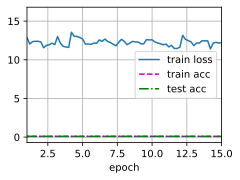

In [41]:
lr, num_epochs = 0.9, 15
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 1.135, train acc 0.571, test acc 0.833
4114.2 examples/sec on cpu


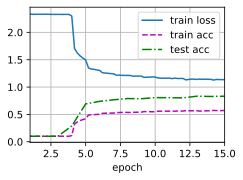

In [42]:
#Normalization - Dropout#
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), nn.Dropout2d(0.2),
                    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.Dropout2d(0.2),
                    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(256, 120), nn.Dropout1d(0.2),
                    nn.Sigmoid(), nn.Linear(120, 84), nn.Dropout1d(0.2),
                    nn.Sigmoid(), nn.Linear(84, 10))

d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())